# Homework 1 - Pytorch, Pytorch Lightning, Model monitoring, Hyper-parameter optimization

Mikołaj Marmurowicz 151956

## Loading required libraries and data

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import optuna
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

d:\Environment\anaconda\envs\pl-hw1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


'cuda'

Creating the dataset class

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, root: str, train: bool, transform=None, download: bool = True):
        self.base = datasets.FashionMNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )
        
    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        image, label = self.base[idx]
        return image, label


Creating Data Module - data loaders

In [ ]:
class FashionMNISTDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data",
        batch_size: int = 64,
        num_workers: int = 0,
        val_split: float = 0.1
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        FashionMNISTDataset(self.data_dir, train=True, transform=self.transform, download=True)
        FashionMNISTDataset(self.data_dir, train=False, transform=self.transform, download=True)

    def setup(self, stage = None):
        if stage in (None, "fit"):
            full_train = FashionMNISTDataset(self.data_dir, train=True, transform=self.transform, download=False)
            n_val = int(len(full_train) * self.val_split)
            n_train = len(full_train) - n_val
            self.train_set, self.val_set = random_split(full_train, [n_train, n_val])

        if stage in (None, "test"):
            self.test_set = FashionMNISTDataset(self.data_dir, train=False, transform=self.transform, download=False)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)


Creating the model

In [ ]:
class LitFashionMNIST(L.LightningModule):
    def __init__(
        self,
        lr: float = 1e-3,
        dropout: float = 0.3,
        hidden_size: int = 128
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 10)
        )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch, stage: str):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            },
        }


## Training

In [10]:
import wandb

WANDB_PROJECT = "pl_hw1_fashionmnist"
WANDB_ENTITY = None

wandb_logger = WandbLogger(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    log_model=True,
    name="baseline_cnn"
)

dm = FashionMNISTDataModule(batch_size=64)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="fashionmnist-{epoch:02d}-{val_loss:.4f}"
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

trainer = L.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_monitor, early_stopping],
    log_every_n_steps=50
)

model = LitFashionMNIST(lr=1e-3, dropout=0.3, hidden_size=128)

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 421 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 11: 100%|██████████| 844/844 [00:10<00:00, 82.56it/s, v_num=zi9m, val_loss=0.242, val_acc=0.926, train_loss=0.0848, train_acc=0.968]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 128.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.92330002784729
        test_loss           0.2728218734264374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2728218734264374, 'test_acc': 0.92330002784729}]

The graphs saved within the Wandb website.

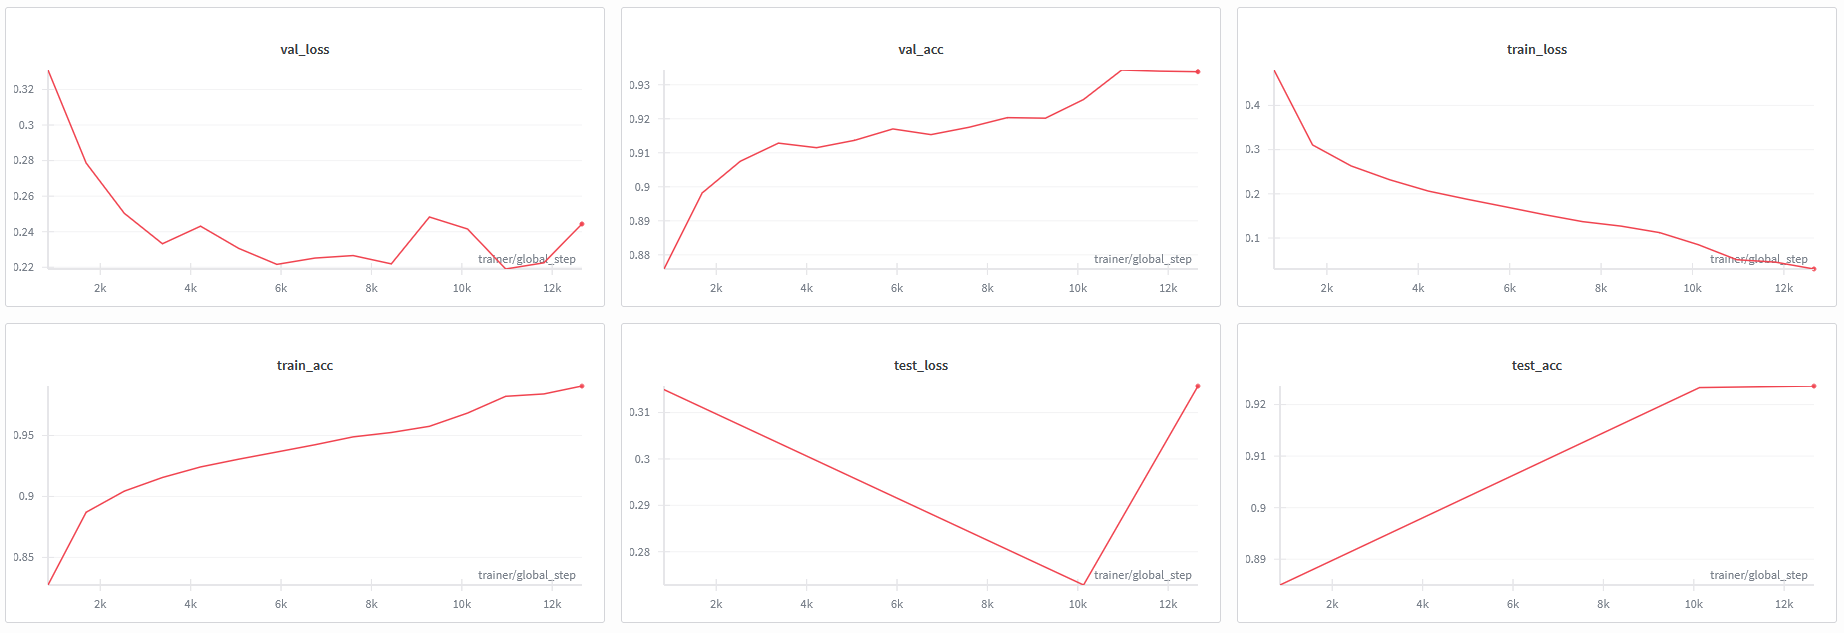

By analyzing the plots presented in the Wandb website we can see that the model is clearly learning. The loss of all three (training, validation and test) sets of data is dropping with training steps, while the accuracies rise. Toward the end of training we can notice a slight increase in validation and test loss, which suggests a mild overfitting.

## Hyper parameter optimization

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128, 256])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    dm = FashionMNISTDataModule(batch_size=batch_size)
    model = LitFashionMNIST(lr=lr, dropout=dropout, hidden_size=hidden_size)
    trainer = L.Trainer(
        max_epochs=8,
        accelerator="auto",
        devices=1,
        logger=False,
        enable_checkpointing=False,
        callbacks=[
            PyTorchLightningPruningCallback(trial, monitor="val_loss")
        ]
    )
    trainer.fit(model, datamodule=dm)
    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss


I have decided to use Optuna to search for the combination of learning rate, dropout, hidden layer size, and batch size that produces the lowest validation loss after only 8 training epochs. That means Optuna is not optimizing for final accuracy or long-run generalization. Instead it focuses on how quickly the model can reduce validation loss in a short training window.

In [ ]:
study = optuna.create_study(
    direction="minimize",
    study_name="fashionmnist_pl_hpo"
)
study.optimize(objective, n_trials=20, timeout=None)
print("Number of finished trials:", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  value (val_loss):", best_trial.value)
print("  params:")
for k, v in best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-11-22 22:24:47,168] A new study created in memory with name: fashionmnist_pl_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 844/844 [00:10<00:00, 76.91it/s, val_loss=0.244, val_acc=0.924, train_loss=0.123, train_acc=0.953]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 844/844 [00:10<00:00, 76.86it/s, val_loss=0.244, val_acc=0.924, train_loss=0.123, train_acc=0.953]

[I 2025-11-22 22:26:14,501] Trial 0 finished with value: 0.2436465471982956 and parameters: {'lr': 0.002199104059594079, 'dropout': 0.2683641989376363, 'hidden_size': 256, 'batch_size': 64}. Best is trial 0 with value: 0.2436465471982956.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 844/844 [00:09<00:00, 86.03it/s, val_loss=0.244, val_acc=0.912, train_loss=0.301, train_acc=0.887]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 844/844 [00:09<00:00, 86.00it/s, val_loss=0.244, val_acc=0.912, train_loss=0.301, train_acc=0.887]

[I 2025-11-22 22:27:39,934] Trial 1 finished with value: 0.2439950406551361 and parameters: {'lr': 0.00294349690828551, 'dropout': 0.49392697056001544, 'hidden_size': 64, 'batch_size': 64}. Best is trial 0 with value: 0.2436465471982956.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 422/422 [00:07<00:00, 56.25it/s, val_loss=0.336, val_acc=0.875, train_loss=0.440, train_acc=0.845]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 422/422 [00:07<00:00, 56.24it/s, val_loss=0.336, val_acc=0.875, train_loss=0.440, train_acc=0.845]

[I 2025-11-22 22:28:39,405] Trial 2 finished with value: 0.3361716568470001 and parameters: {'lr': 0.0001380318807856354, 'dropout': 0.4703855370231228, 'hidden_size': 64, 'batch_size': 128}. Best is trial 0 with value: 0.2436465471982956.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 421 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 844/844 [00:09<00:00, 85.09it/s, val_loss=0.277, val_acc=0.896, train_loss=0.260, train_acc=0.906]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 844/844 [00:09<00:00, 85.07it/s, val_loss=0.277, val_acc=0.896, train_loss=0.260, train_acc=0.906]

[I 2025-11-22 22:29:58,939] Trial 3 finished with value: 0.27677613496780396 and parameters: {'lr': 0.00014136748527503616, 'dropout': 0.2124562934764177, 'hidden_size': 128, 'batch_size': 64}. Best is trial 0 with value: 0.2436465471982956.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 422/422 [00:07<00:00, 57.96it/s, val_loss=0.239, val_acc=0.914, train_loss=0.228, train_acc=0.915]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 422/422 [00:07<00:00, 57.92it/s, val_loss=0.239, val_acc=0.914, train_loss=0.228, train_acc=0.915]

[I 2025-11-22 22:30:58,693] Trial 4 finished with value: 0.23881520330905914 and parameters: {'lr': 0.005214862095246964, 'dropout': 0.2911240495641467, 'hidden_size': 256, 'batch_size': 128}. Best is trial 4 with value: 0.23881520330905914.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 844/844 [00:10<00:00, 84.09it/s, val_loss=0.236, val_acc=0.919, train_loss=0.210, train_acc=0.923]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 844/844 [00:10<00:00, 84.08it/s, val_loss=0.236, val_acc=0.919, train_loss=0.210, train_acc=0.923]

[I 2025-11-22 22:32:19,382] Trial 5 finished with value: 0.23646235466003418 and parameters: {'lr': 0.0024625372552331973, 'dropout': 0.3825444065751178, 'hidden_size': 64, 'batch_size': 64}. Best is trial 5 with value: 0.23646235466003418.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 422/422 [00:07<00:00, 58.11it/s]                  

[I 2025-11-22 22:32:27,539] Trial 6 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 422/422 [00:07<00:00, 56.37it/s]                  

[I 2025-11-22 22:32:35,892] Trial 7 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 844/844 [00:10<00:00, 81.84it/s]                  

[I 2025-11-22 22:32:47,297] Trial 8 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 844/844 [00:09<00:00, 85.40it/s]                  

[I 2025-11-22 22:32:58,294] Trial 9 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 421 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1688/1688 [00:14<00:00, 117.63it/s]               

[I 2025-11-22 22:33:14,075] Trial 10 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1688/1688 [00:16<00:00, 105.13it/s, val_loss=0.273, val_acc=0.916, train_loss=0.128, train_acc=0.952]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1688/1688 [00:16<00:00, 105.11it/s, val_loss=0.273, val_acc=0.916, train_loss=0.128, train_acc=0.952]

[I 2025-11-22 22:35:20,759] Trial 11 finished with value: 0.27269595861434937 and parameters: {'lr': 0.001300706405465752, 'dropout': 0.10313754958447954, 'hidden_size': 64, 'batch_size': 32}. Best is trial 5 with value: 0.23646235466003418.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 422/422 [00:07<00:00, 59.79it/s]                  

[I 2025-11-22 22:35:28,718] Trial 12 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 422/422 [00:07<00:00, 59.43it/s, val_loss=0.313, val_acc=0.887, train_loss=0.505, train_acc=0.817]

[I 2025-11-22 22:35:44,409] Trial 13 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 421 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1688/1688 [00:15<00:00, 105.94it/s, val_loss=0.240, val_acc=0.920, train_loss=0.168, train_acc=0.936]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1688/1688 [00:15<00:00, 105.93it/s, val_loss=0.240, val_acc=0.920, train_loss=0.168, train_acc=0.936]


[I 2025-11-22 22:37:52,300] Trial 14 finished with value: 0.23953787982463837 and parameters: {'lr': 0.0014302855804561286, 'dropout': 0.39352836951362874, 'hidden_size': 128, 'batch_size': 32}. Best is trial 5 with value: 0.23646235466003418.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 844/844 [00:10<00:00, 84.30it/s]                  

[I 2025-11-22 22:38:03,384] Trial 15 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 422/422 [00:07<00:00, 58.24it/s]                  

[I 2025-11-22 22:38:11,515] Trial 16 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 844/844 [00:10<00:00, 79.11it/s, val_loss=0.227, val_acc=0.925, train_loss=0.123, train_acc=0.954]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 844/844 [00:10<00:00, 79.11it/s, val_loss=0.227, val_acc=0.925, train_loss=0.123, train_acc=0.954]

[I 2025-11-22 22:39:37,299] Trial 17 finished with value: 0.22704675793647766 and parameters: {'lr': 0.0008339802352744992, 'dropout': 0.2266455049847091, 'hidden_size': 256, 'batch_size': 64}. Best is trial 17 with value: 0.22704675793647766.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 220 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 422/422 [01:43<00:00,  4.07it/s]


[I 2025-11-22 22:39:48,228] Trial 18 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 421 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 844/844 [00:10<00:00, 84.03it/s]                  

[I 2025-11-22 22:39:59,317] Trial 19 pruned. Trial was pruned at epoch 0.


Number of finished trials: 20
Best trial:
  value (val_loss): 0.22704675793647766
  params:
    lr: 0.0008339802352744992
    dropout: 0.2266455049847091
    hidden_size: 256
    batch_size: 64


The optimization process run for 20 trials and identified progressively configurations that yielded higher model generalization on early epochs. The baseline model achieved validation loss of about 0.26 after 15 epochs, while this model achieved validation loss of 0.227 after just 8. The final best parameters for my problem of good early generalization are as follows: lr = 0.000833, dropout = 0.226645, hidden size = 256, and the batch size = 64.

## Testing the final hyperparameter optimized model

In [9]:
best_params = study.best_trial.params
best_lr = best_params["lr"]
best_dropout = best_params["dropout"]
best_hidden_size = best_params["hidden_size"]
best_batch_size = best_params["batch_size"]
print("Using best params:", best_params)
dm_best = FashionMNISTDataModule(batch_size=best_batch_size)
wandb_logger_best = WandbLogger(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    log_model=True,
    name="best_optuna_cnn"
)
checkpoint_callback_best = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="fashionmnist-optuna-{epoch:02d}-{val_loss:.4f}"
)
trainer_best = L.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices=1,
    logger=wandb_logger_best,
    callbacks=[checkpoint_callback_best, lr_monitor],
    log_every_n_steps=50
)
model_best = LitFashionMNIST(
    lr=best_lr,
    dropout=best_dropout,
    hidden_size=best_hidden_size
)
trainer_best.fit(model_best, datamodule=dm_best)
trainer_best.test(model_best, datamodule=dm_best)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
d:\Environment\anaconda\envs\pl-hw1\Lib\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
d:\Environment\anaconda\envs\pl-hw1\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory .\pl_hw1_fashionmnist\3sahzi9m\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 824 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
824 K     Trainable params
0         Non-trainable params
824 K     Total params
3.298     Total estimated model params size (MB)
13    

Using best params: {'lr': 0.0008339802352744992, 'dropout': 0.2266455049847091, 'hidden_size': 256, 'batch_size': 64}
                                                                            

d:\Environment\anaconda\envs\pl-hw1\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Environment\anaconda\envs\pl-hw1\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 844/844 [00:12<00:00, 69.77it/s, v_num=zi9m, val_loss=0.244, val_acc=0.934, train_loss=0.0299, train_acc=0.991]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 844/844 [00:12<00:00, 69.74it/s, v_num=zi9m, val_loss=0.244, val_acc=0.934, train_loss=0.0299, train_acc=0.991]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Environment\anaconda\envs\pl-hw1\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 119.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9236000180244446
        test_loss           0.3157264292240143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3157264292240143, 'test_acc': 0.9236000180244446}]

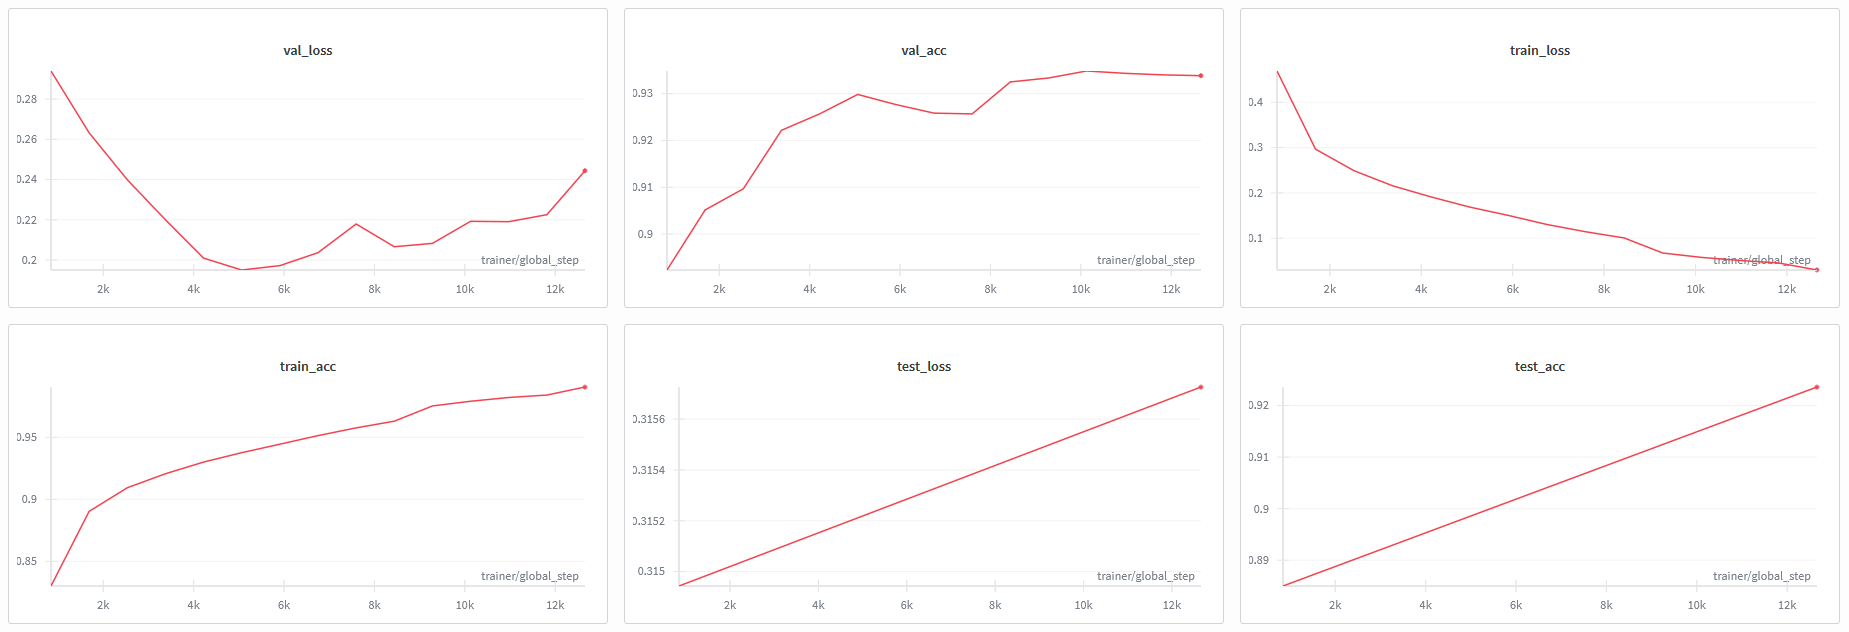

The results show that although the overall performance remains similar, the validation loss reaches its minimum very early in training and then begins to rise sharply. This indicates that the model starts to overfit much faster with the newly selected hyperparameters. This behavior was expected, particularly because the early-stopping mechanism was intentionally disabled for the experiment. The hyperparameter optimization itself was effective, as it found a configuration that achieves strong performance quickly, but the experiment highlights the fact that: when hyperparameters change, the accompanying training conditions (such as early stopping, learning-rate scheduling, and regularization strategies) must also be adjusted accordingly. Without aligning these components, even well-optimized hyperparameters can lead to unstable or overfitting-prone training dynamics.

## Main problems encountered

1. Remember to actually enter your W&B API key. Otherwise you’ll sit there waiting for logs that will never show up, wondering what you did wrong.
2. Hyperparameter optimization is slow, so it pays to decide what you truly want from it. I tried exploring how quickly the model could become “good,” but afterward I realized it would’ve been more useful to search for parameters that clearly improve final test accuracy - much easier to analyze in the end.